Re-do ICA finalized code on my Github.  These *should* produce more accurate reconstructions, especially with spectra which have a lot of their wavelength coverage masked, but we'll see.  Either way, should declare victory after these.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('.'))+"\\components")
sys.path.append(os.path.abspath(os.path.join('.'))+"\\ICA Scripts")

import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib
# import richardsplot as rplot

from astropy.io import fits
from astropy.table import Table
import pandas as pd

#sys.path.append("/Volumes/Macintosh HD 1/Users/trevormccaffrey/Desktop/HST/AllHSTCode/")
# sys.path.append("/Users/trevormccaffrey/Dropbox/HST/HSTCode/")
#sys.path.append("/Users/trevormccaffrey/Dropbox/HST/HSTCode/")
from Small_Pix_Filter_TVM import SDSS_pixel_filter
import MorphingEdges_FOS
import MorphingEdges_STIS
import MorphingEdges_COS
import MorphingEdges_HSLA
import MorphingEdges
import CIV_BAL_regions
#Use the package that Amy used for determining weights
from lmfit import minimize, Parameters

# sys.path.append("/Users/trevormccaffrey/Dropbox/ICA_module/code_main/")
#sys.path.append("/Users/Trevor1/Dropbox/ICA_module/")
import run_ICA_r20_components
import components
import spec_morph

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True

---

In [4]:
ica_path = "/Users/trevormccaffrey/Dropbox/HST/ICA/"

In [3]:
%%capture
def blueshift(wave_half_flux):
    return ((1549.48 - wave_half_flux) / 1549.48) * 3e5

def get_CIV(wave, flux, wave_r, flux_r, name, ax=plt.gca(), EW_region=[1500,1600], cont_region=[[1445,1465],[1700,1705]], good=1):
    #print("Getting CIV")
    #Going to save plots, but not show with magic above
    #"""
    ylow, yup = max(0, np.percentile(flux_r, 1)-np.nanmedian(flux_r)/5), np.percentile(flux_r, 99)+np.nanpercentile(flux_r, 95)
    #fig, ax = plt.subplots(figsize=(9,9))
    #fig = plt.figure(figsize=(9,9))
    ax.plot(wave, flux, "-k", alpha=0.5)#, label="HST co-add")
    ax.plot(wave_r, flux_r, "-r", lw=1.8)#, label="ICA fit")
    ax.plot([1549.48,1549.48], [ylow,yup], "--k", label="CIV Rest")
    #"""
    
    #Fit continuum -- ADD MANUAL HERE
    cont1 = ((wave_r>=cont_region[0][0])&(wave_r<=cont_region[0][1]))
    cont2 = ((wave_r>=cont_region[1][0])&(wave_r<=cont_region[1][1]))
    ax.axvspan(cont_region[0][0], cont_region[0][1], alpha=0.5, color='grey')
    ax.axvspan(cont_region[1][0], cont_region[1][1], alpha=0.5, color='grey')

    m,b = np.polyfit(np.concatenate((wave_r[cont1], wave_r[cont2])), np.concatenate((flux_r[cont1], flux_r[cont2])), 1)
    continuum = wave_r*m + b
    ax.plot(wave_r, continuum, "-m")
    
    #Plot EW region under flux_r -- ADD MANUAL HERE
    EW = ((wave_r>=EW_region[0])&(wave_r<=EW_region[1]))

    #And compute the EW
    CIV_EW = 0
    ew_list = [0.]
    for i in range(len(wave_r[EW])):
        try:
            CIV_EW += max(( (flux_r[EW][i] - continuum[i]) / continuum[i] ) * ( wave_r[EW][i+1] - wave_r[EW][i] ), 0) #no absorption
        except IndexError:
            CIV_EW += max(( (flux_r[EW][i] - continuum[i]) / continuum[i] ) * ( wave_r[EW][i] - wave_r[EW][i-1] ), 0)

        ew_list.append(CIV_EW)

    ax.fill_between(wave_r[EW], continuum[EW], flux_r[EW], color="blue", alpha=0.2, label="%.1f Å"%CIV_EW)

    ind_half_flux = abs((CIV_EW / 2) - np.array(ew_list)).argmin()
    CIV_blue = blueshift(wave_r[EW][ind_half_flux])
    #"""  
    #for w in np.arange(1450,1530,10): ax.plot([w,w],[ylow,yup],"--",label=str(w))
    #for w in np.arange(1610,1640,10): ax.plot([w,w],[ylow,yup],"--",label=str(w))
    ax.plot([EW_region[0],EW_region[0]], [ylow,yup], "-b", alpha=0.7)
    ax.plot([EW_region[1],EW_region[1]], [ylow,yup], "-b", alpha=0.7)
    ax.plot([wave_r[EW][ind_half_flux],wave_r[EW][ind_half_flux]], [ylow,yup], "--b", label="%.1f km/s" % (CIV_blue))
    ax.set_xlim(1435, 1710)
    ax.set_ylim(ylow, yup)
    ax.set_xlabel("Wavelength (Å)", fontsize=20)
    #ax.set_ylabel("Flux (Arbitrary Units)", fontsize=20)
    #ax.set_title("Blue, EW = %.2f km/s, %.2f Å" % (CIV_blue,CIV_EW), fontsize=20)
    ax.set_title(name, fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=17.5)
    ax.tick_params(axis='both', which='minor', labelsize=17.5)
    ax.tick_params(labelleft=False)
    ax.legend(loc="best", prop={"size":12.5})
    #plt.tight_layout()
    """
    if good == 1:
        plt.savefig("/Users/Trevor1/Dropbox/HST/CIV_fits_final/good/%s.png"%name)
    else:
        plt.savefig("/Users/Trevor1/Dropbox/HST/CIV_fits_final/bad/%s.png"%name)
    #plt.show()
    """    
    return CIV_blue, CIV_EW

In [6]:
!ls /Users/trevormccaffrey/Dropbox/HST/final_tables

BASS-DR2
HST_CIV_Sulentic2007_HSLA2015.csv
HST_CIV_Sulentic2007_HSLA2015_shiftgue.csv
HST_CIV_Sulentic2007_HSLA2018.csv
HST_CIV_Sulentic2007_HSLA2018_1Jan2023.csv
HST_CIV_Sulentic2007_HSLA2018_1Jan2023_HSLAandSul07.csv
HST_CIV_Sulentic2007_HSLA2018_29Dec2022.csv
HST_CIV_Sulentic2007_HSLA2018_finalprops.csv
HST_CIV_Sulentic2007_HSLA2018_finalprops_BASS-DR2match300arcsec.csv
HST_mbh_9FebAfternoon.csv
HST_mbh_9FebMorning.csv
HST_plus_GNIRS_MbhLedd.csv
Koss2022BAT_TVMmatch300arcsec.fits
Koss22BAT_apjsac6c05t9_mrt.fits
Sulentic07_table1.dat.fits
Sulentic07_table2.dat.fits
matching


In [4]:
dat = pd.read_csv("HST_CIV_Sulentic2007_HSLA2018_finalprops.csv")
dat.head(30)

,Final_Name,Alt_Name,Inst_final,z,z_src,CIV_blue_tvm,CIV_EW_tvm,_RA,_DE,Sul_Name,...,logLEdd,logLEdd_Source,logLEdd_Source_qual,F2500 (ergs/s/cm2/A),F2500_change,logLbol_2500 (erg/s),logLedd (erg/s),logEddRatio_2500,CIV_Distance,Spec_Name
0,1H 0707-495,2MASS J07084147-4933063,STIS,0.040800,Sul,1437.482252,6.095122,107.173050,-49.551842,J07086-4933,...,NaN,NaN,NaN,6.785221e-15,6.785221e-15,44.295900,44.400371,-0.104471,0.896653,J07086-4933
1,1H 1613-097,2MASS J16151905-0936132,HSLA,0.064960,https://arxiv.org/pdf/2108.11958.pdf,59.381212,68.570031,243.829000,-9.603690,NaN,...,NaN,NaN,NaN,2.591391e-15,2.591391e-15,44.296881,45.040371,-0.743489,0.395527,1H1613-097
2,2E 1013,PKS 0420-01,FOS,0.915000,Sul,-78.781269,58.892013,65.815836,-1.342518,J04232-0120,...,NaN,NaN,NaN,2.515154e-16,2.515154e-16,45.877265,47.130371,-1.253106,0.432297,J04232-0120
3,2E 1135,PKS 0439-43,FOS,0.593800,Sul,335.512559,68.375473,70.322167,-43.229278,J04412-4313,...,NaN,NaN,NaN,1.229594e-15,1.229594e-15,46.103335,46.180371,-0.077036,0.396815,J04412-4313
4,2E 1644,IRAS L06229-6434,HSLA,0.129000,https://arxiv.org/pdf/1710.10703.pdf,-493.636575,80.774877,95.782000,-64.605800,NaN,...,NaN,NaN,NaN,5.858584e-15,5.858584e-15,45.271568,45.900371,-0.628803,0.352018,IRAS-L06229-6434
5,2E 2889,PKS 1252+11,FOS,0.873700,Sul,1162.377056,12.281426,193.659402,11.684962,J12546+1141,...,NaN,NaN,NaN,9.201820e-16,9.201820e-16,46.384352,47.020371,-0.636019,0.801316,J12546+1141
6,2E 3345,PKS 1451-37,FOS,0.314000,Sul,-701.286883,139.463222,223.614207,-37.792540,J14544-3747,...,NaN,NaN,NaN,1.083115e-15,1.083115e-15,45.400887,46.920371,-1.519483,0.210293,J14544-3747
7,2E 4226,ESO 141-55,HSLA,0.037109,NED,128.443091,56.782657,290.309000,-58.670300,NaN,...,45.14,Koss+17,1.5,4.056582e-14,4.056582e-14,44.978724,46.090371,-1.111647,0.444949,ESO-141-55
8,2E 935,PKS 0403-13,FOS,0.570500,Sul,-701.286883,89.429322,61.391699,-13.137157,J04055-1308,...,NaN,NaN,NaN,7.505590e-16,7.980000e-16,45.876466,47.220371,-1.343904,0.325265,J04055-1308
9,2MASS J00481898+3941116,1RXSÂ J004819.6+394110,HSLA,0.135000,"Borisov, Voikhanskaya & Fabrika 1991",128.443091,48.546950,12.079100,39.686600,NaN,...,NaN,NaN,NaN,5.443617e-15,5.443617e-15,45.282349,NaN,NaN,0.479719,QSO0045+3926


In [5]:
dat.columns

Index(['Final_Name', 'Alt_Name', 'Inst_final', 'z', 'z_src', 'CIV_blue_tvm',
       'CIV_EW_tvm', '_RA', '_DE', 'Sul_Name', 'SDSS_NAME', 'PLATE', 'MJD',
       'FIBERID', 'F1450_spec (erg/s/cm2/A)', 'S2N_1450A', 'CIVgood_manmask',
       'F1550_sul07', 'c1_2_sul07', 'log M_BH', '+err(log M_BH)',
       '-err(log M_BH)', 'MBH_source', 'MBH_source_qual', 'logEddRatio',
       'EddRatio_Source', 'EddRatio_Source_qual', 'LBol', 'LBol Source',
       'LBol_Source_qual', 'logLEdd', 'logLEdd_Source', 'logLEdd_Source_qual',
       'F2500 (ergs/s/cm2/A)', 'F2500_change', 'logLbol_2500 (erg/s)',
       'logLedd (erg/s)', 'logEddRatio_2500', 'CIV_Distance', 'Spec_Name'],
      dtype='object')

In [6]:
names = dat["Final_Name"].values
names_spec = dat["Spec_Name"].values
inst_final = dat["Inst_final"].values

In [8]:
(names=="NGC5548").sum()

0

In [11]:
! ls /Users/Trevor1/Dropbox/HST/RebinnedSpec_2022Aug11

ls: /Users/Trevor1/Dropbox/HST/RebinnedSpec_2022Aug11: No such file or directory


In [7]:
dat

,Final_Name,Alt_Name,Inst_final,z,z_src,CIV_blue_tvm,CIV_EW_tvm,_RA,_DE,Sul_Name,...,logLEdd,logLEdd_Source,logLEdd_Source_qual,F2500 (ergs/s/cm2/A),F2500_change,logLbol_2500 (erg/s),logLedd (erg/s),logEddRatio_2500,CIV_Distance,Spec_Name
0,1H 0707-495,2MASS J07084147-4933063,STIS,0.04080,Sul,1437.482252,6.095122,107.173050,-49.551842,J07086-4933,...,NaN,NaN,NaN,6.785221e-15,6.785221e-15,44.295900,44.400371,-0.104471,0.896653,J07086-4933
1,1H 1613-097,2MASS J16151905-0936132,HSLA,0.06496,https://arxiv.org/pdf/2108.11958.pdf,59.381212,68.570031,243.829000,-9.603690,NaN,...,NaN,NaN,NaN,2.591391e-15,2.591391e-15,44.296881,45.040371,-0.743489,0.395527,1H1613-097
2,2E 1013,PKS 0420-01,FOS,0.91500,Sul,-78.781269,58.892013,65.815836,-1.342518,J04232-0120,...,NaN,NaN,NaN,2.515154e-16,2.515154e-16,45.877265,47.130371,-1.253106,0.432297,J04232-0120
3,2E 1135,PKS 0439-43,FOS,0.59380,Sul,335.512559,68.375473,70.322167,-43.229278,J04412-4313,...,NaN,NaN,NaN,1.229594e-15,1.229594e-15,46.103335,46.180371,-0.077036,0.396815,J04412-4313
4,2E 1644,IRAS L06229-6434,HSLA,0.12900,https://arxiv.org/pdf/1710.10703.pdf,-493.636575,80.774877,95.782000,-64.605800,NaN,...,NaN,NaN,NaN,5.858584e-15,5.858584e-15,45.271568,45.900371,-0.628803,0.352018,IRAS-L06229-6434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,Ton S 180,PHL 912,STIS,0.06200,Sul,542.446498,18.535372,14.334174,-22.382344,J00573-2222,...,NaN,NaN,NaN,1.799458e-14,1.799458e-14,45.085694,45.160371,-0.074676,0.681286,TONS180
203,Ton S 210,1ESÂ 0119-28.6,HSLA,0.11600,https://arxiv.org/pdf/1507.06317.pdf,266.508764,26.374028,20.464600,-28.349400,NaN,...,NaN,NaN,NaN,1.520099e-14,1.520099e-14,45.581928,46.280371,-0.698443,0.590919,TONS210
204,UKS 0242-72.4,2MASS J02430960-7216482,HSLA,0.10200,NED,404.496993,34.428128,40.790000,-72.280100,NaN,...,NaN,NaN,NaN,4.496579e-15,4.496579e-15,44.941670,NaN,NaN,0.561679,UKS-0242-724
205,VIII Zw 233,SDSSÂ J130534.49+181932.9,HSLA,0.11800,DR16,-217.001833,32.895908,196.394000,18.325800,NaN,...,NaN,NaN,NaN,1.167308e-15,1.167308e-15,44.497620,46.480371,-1.982751,0.517155,NEWQZ004


In [8]:
CIV_BAL_regions.BAL_regions

{'3C207': [[1544.5, 1552], [2200, 3000]],
 '3C232': [[1250, 1360],
  [1530, 1542],
  [1546.7, 1566],
  [1680, 1720],
  [1790, 1905],
  [2120, 3000]],
 '3C254': [[1430, 1445], [1599, 1625], [2100, 3000]],
 '3C273': [[2200, 2900]],
 '3C281': [[2400, 3000]],
 '3C334': [[2400, 3000]],
 '3C336': [[1950, 3000]],
 '3C345': [[2200, 3000]],
 '3C390': [[1535, 1549.1], [1578, 1590], [1880, 1908], [2600, 3000]],
 '3C454': [[1495, 1517]],
 'Ark120': [[1555, 1563]],
 'B21425+26': [[1540, 1554], [1890, 1910], [2750, 3000]],
 'ESO462-G09': [[1200, 1300]],
 'FBQSJ074541.6+314256': [[2500, 3000]],
 'HE0132-4313': [[1250, 1360], [1950, 2350], [2500, 2900]],
 'J00535+1241': [[1255, 1490], [1526, 1535], [1543, 1546], [1690, 3000]],
 'J01376-2430': [[1546, 1552]],
 'J05198-4546': [[1260, 1430], [1534, 1540], [2235, 3000]],
 'J06357-7516': [[1680, 1700]],
 'J07086-4933': [[1275, 1351], [1462, 1495], [1540, 1548]],
 'J08535+4349': [[2200, 3000]],
 'J09270+3902': [[1250, 1390], [1645, 1657], [2100, 3000]],
 'J

In [9]:
def plot_HST(wave, flux, mask, ax):
    iplot_start = 0
    #iplot_end   = 0
    mask_curr   = mask[0]
    for i in range(len(wave)):
        #go until mask is a different value
        if mask[i]!=mask_curr or i==len(wave)-1:
            if mask_curr==3:
                #plot BAL region
                ax.plot(wave[iplot_start:i], flux[iplot_start:i], "-m", zorder=2)
            elif mask_curr==2:
                #plot NAL region
                ax.plot(wave[iplot_start:i], flux[iplot_start:i], "-y", zorder=2)
            elif mask_curr==1:
                #plot badpix region
                ax.plot(wave[iplot_start:i], flux[iplot_start:i], "-r", zorder=2)
            else:
                #plot BAL region
                ax.plot(wave[iplot_start:i], flux[iplot_start:i], "-k", zorder=1)

            mask_curr = mask[i]
            iplot_start = i-1

In [12]:
for i in range(len(names)):
    # names[i] = "-".join(names[i].split(" "))
    names[i] = "".join(names[i].split(" "))


In [13]:
print(names)

['1H0707-495' '1H1613-097' '2E1013' '2E1135' '2E1644' '2E2889' '2E3345'
 '2E4226' '2E935' '2MASSJ00481898+3941116' '2MASSJ10053274-2417161'
 '3C057' '3C095' '3C110' '3C207' '3C215' '3C232' '3C249.1' '3C254' '3C263'
 '3C273' '3C277.1' '3C281' '3C323.1' '3C334' '3C336' '3C345' '3C351.0'
 '3C390' '3C454' '4C-01.61' '4C-03.79' '4C01.04' '4C09.72' '4C09.74'
 '4C10.06' '4C11.72' '4C15.01' '4C16.30' '4C19.44' '4C31.63' '4C37.43'
 '4C39.25' '4C49.22' '4C61.20' '4C63.15' '4C73.18' '6C134441+623604'
 '7C1156+2123' '7C1821+6419' 'Ark120' 'Ark564' 'CrtA' 'ESO31-8' 'ESO462-9'
 'ESO499-41' 'Fairall9' 'FBQSJ0012-1022' 'FBQSJ0745+3142' 'FBQSJ1010+3003'
 'FBQSJ1010+4132' 'FBQSJ1030+3102' 'FBQSJ1251+2404' 'HE0132-4313'
 'HS0033+4300' 'HS0624+6907' 'IZw1' 'IRAS13224-3809' 'IRASF04250-5718'
 'IRASF22456-5125' 'LBQS0003+0146' 'LBQS0017+0209' 'LBQS0100+0205'
 'LBQS0307-0101' 'LBQS1132-0302' 'LBQS1138+0204' 'LBQS1144-0115'
 'LBQS1230+0947' 'LBQS1317-0142' 'LEDA2172' 'MR2251-178' 'Mrk1018'
 'Mrk1044' 'Mrk106'

['STIS' 'HSLA' 'FOS' 'FOS' 'HSLA' 'FOS' 'FOS' 'HSLA' 'FOS' 'HSLA' 'HSLA'
 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS'
 'FOS' 'FOS' 'FOS' 'FOS' 'STIS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS'
 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS'
 'HSLA' 'FOS' 'FOS' 'FOS' 'STIS' 'FOS' 'HSLA' 'HSLA' 'HSLA' 'FOS' 'HSLA'
 'FOS' 'HSLA' 'FOS' 'FOS' 'HSLA' 'FOS' 'HSLA' 'FOS' 'FOS' 'STIS' 'HSLA'
 'HSLA' 'FOS' 'FOS' 'FOS' 'HSLA' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'HSLA'
 'HSLA' 'HSLA' 'HSLA' 'HSLA' 'HSLA' 'HSLA' 'HSLA' 'HSLA' 'HSLA' 'FOS'
 'HSLA' 'HSLA' 'HSLA' 'HSLA' 'HSLA' 'FOS' 'STIS' 'STIS' 'FOS' 'HSLA'
 'HSLA' 'HSLA' 'FOS' 'FOS' 'FOS' 'STIS' 'HSLA' 'FOS' 'HSLA' 'STIS' 'STIS'
 'FOS' 'FOS' 'HSLA' 'HSLA' 'FOS' 'HSLA' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS'
 'HSLA' 'HSLA' 'HSLA' 'FOS' 'FOS' 'FOS' 'FOS' 'HSLA' 'FOS' 'FOS' 'FOS'
 'FOS' 'FOS' 'HSLA' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'STIS' 'FOS'
 'STIS' 'FOS' 'FOS' 'FOS' 'FOS' 'HSLA' 'FOS' 'FOS' 'STIS' 'FOS' 'HSLA

C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\fit_composites.py:68: RuntimeWarning: divide by zero encountered in divide
  fit_y  = fit_comp(composite_fit, wave[wavecoverage_mask][:-1], flux[wavecoverage_mask][:-1], 1/(errs[wavecoverage_mask][:-1]**2), mask[wavecoverage_mask][:-1])
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:321: RuntimeWarning: divide by zero encountered in divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1], priors=prior_mod)
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:330: RuntimeWarning: divide by zero encountered in divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1], priors=prior_low)
C:\Users\Alexandros Pratsos\

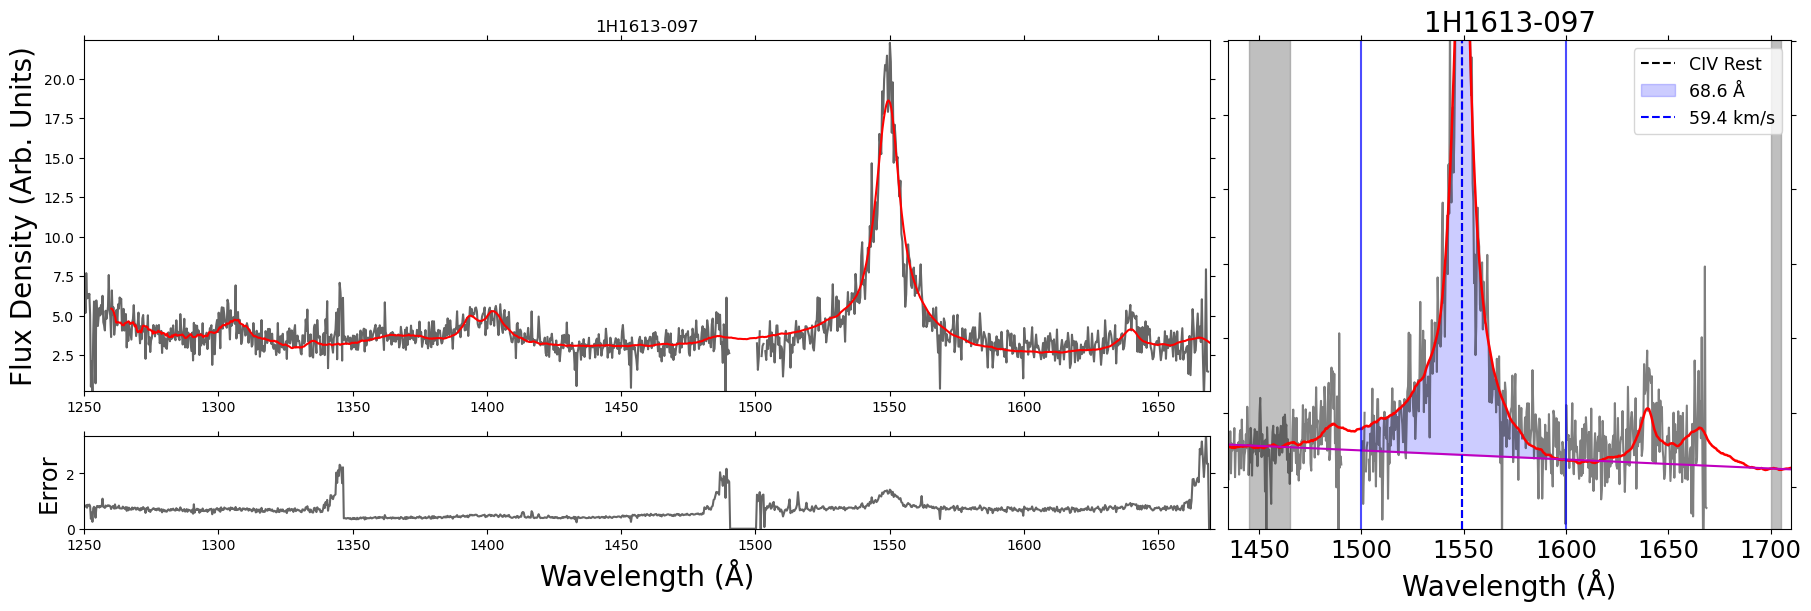

[]
2E1013
[]
2E1135
[]
2E1644
[]
2E2889
[]
2E3345
[]
2E4226
[]
2E935
[]
2MASSJ00481898+3941116
[]
2MASSJ10053274-2417161
['RebinnedSpec_2022Aug11\\3C057_FOS.fits']
ind1: 96, ind2: 613.
ind1: 613, ind2: 1121.
ind1: 1121, ind2: 1786.
ind1: 1786, ind2: 2084.
ind1: 2084, ind2: 2419.


C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\spec_morph.py:369: RuntimeWarning: All-NaN slice encountered
  med_flux[k] = np.nanmedian(flux[(~em)&(waverange)])
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\fit_composites.py:68: RuntimeWarning: divide by zero encountered in divide
  fit_y  = fit_comp(composite_fit, wave[wavecoverage_mask][:-1], flux[wavecoverage_mask][:-1], 1/(errs[wavecoverage_mask][:-1]**2), mask[wavecoverage_mask][:-1])
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:321: RuntimeWarning: divide by zero encountered in divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1], priors=prior_mod)
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:330: RuntimeWarning: divide by z

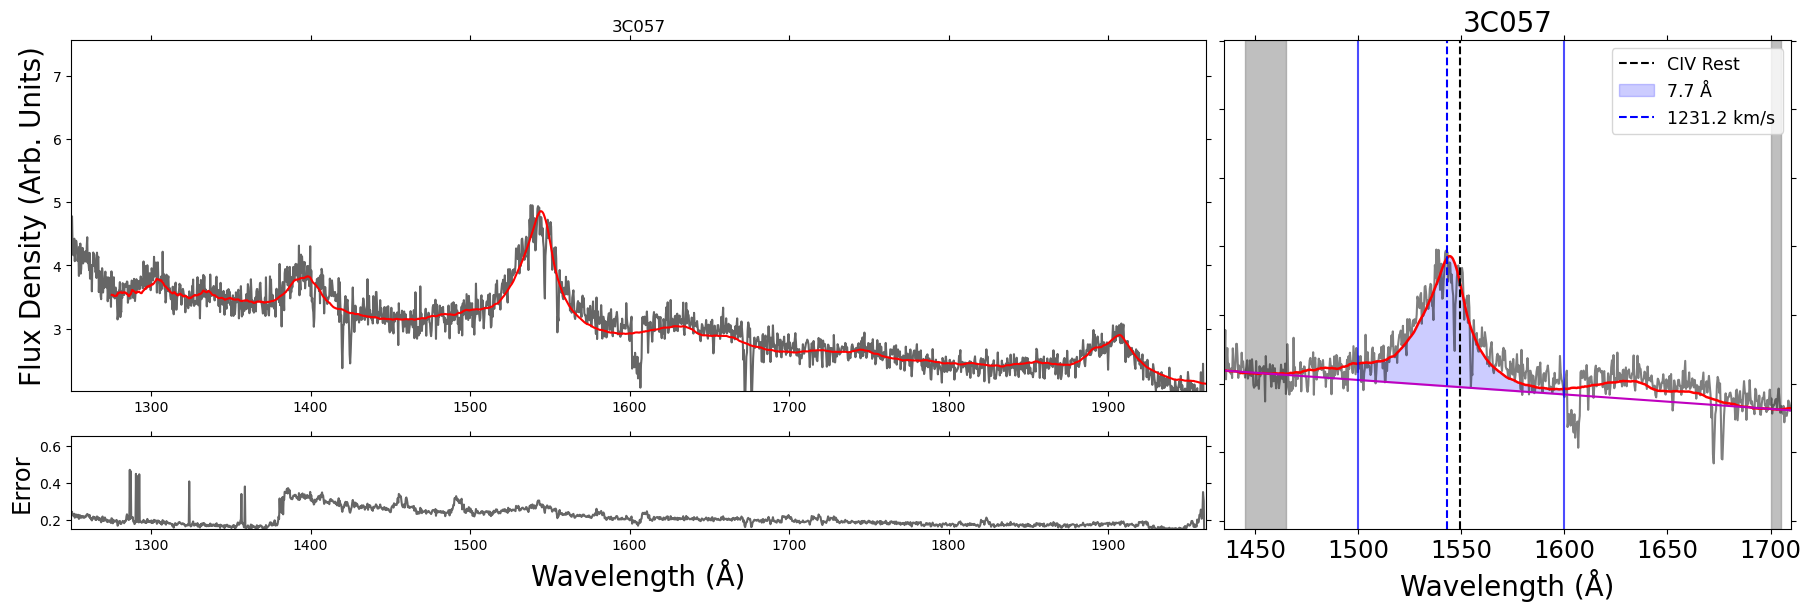

['RebinnedSpec_2022Aug11\\3C095_FOS.fits']


C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\fit_composites.py:68: RuntimeWarning: divide by zero encountered in divide
  fit_y  = fit_comp(composite_fit, wave[wavecoverage_mask][:-1], flux[wavecoverage_mask][:-1], 1/(errs[wavecoverage_mask][:-1]**2), mask[wavecoverage_mask][:-1])
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:321: RuntimeWarning: divide by zero encountered in divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1], priors=prior_mod)
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:330: RuntimeWarning: divide by zero encountered in divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1], priors=prior_low)
C:\Users\Alexandros Pratsos\

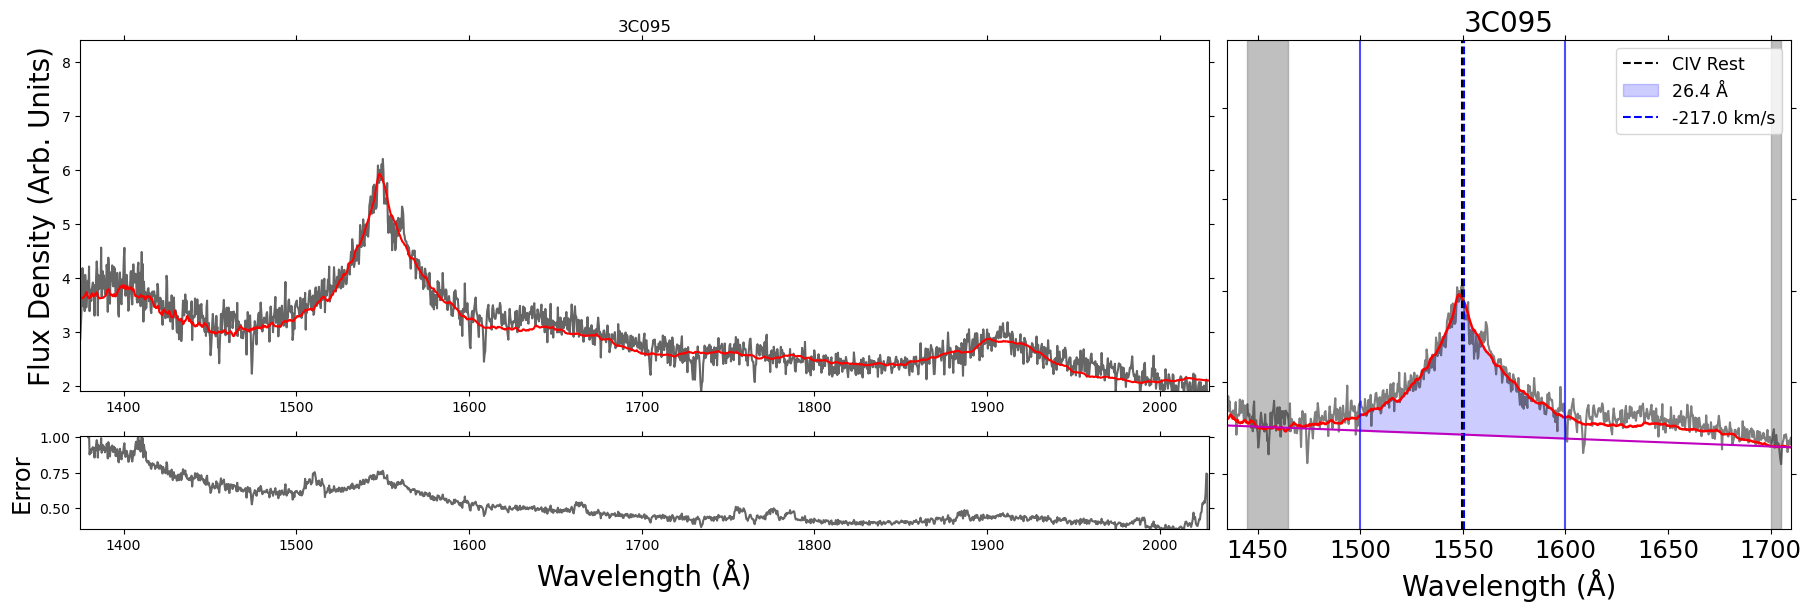

['RebinnedSpec_2022Aug11\\3C110_FOS.fits']
ind1: 96, ind2: 613.
ind1: 613, ind2: 1121.
ind1: 1121, ind2: 1786.
ind1: 1786, ind2: 2084.
ind1: 2084, ind2: 2167.


C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\fit_composites.py:68: RuntimeWarning: divide by zero encountered in divide
  fit_y  = fit_comp(composite_fit, wave[wavecoverage_mask][:-1], flux[wavecoverage_mask][:-1], 1/(errs[wavecoverage_mask][:-1]**2), mask[wavecoverage_mask][:-1])
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:321: RuntimeWarning: divide by zero encountered in divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1], priors=prior_mod)
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:330: RuntimeWarning: divide by zero encountered in divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1], priors=prior_low)
C:\Users\Alexandros Pratsos\

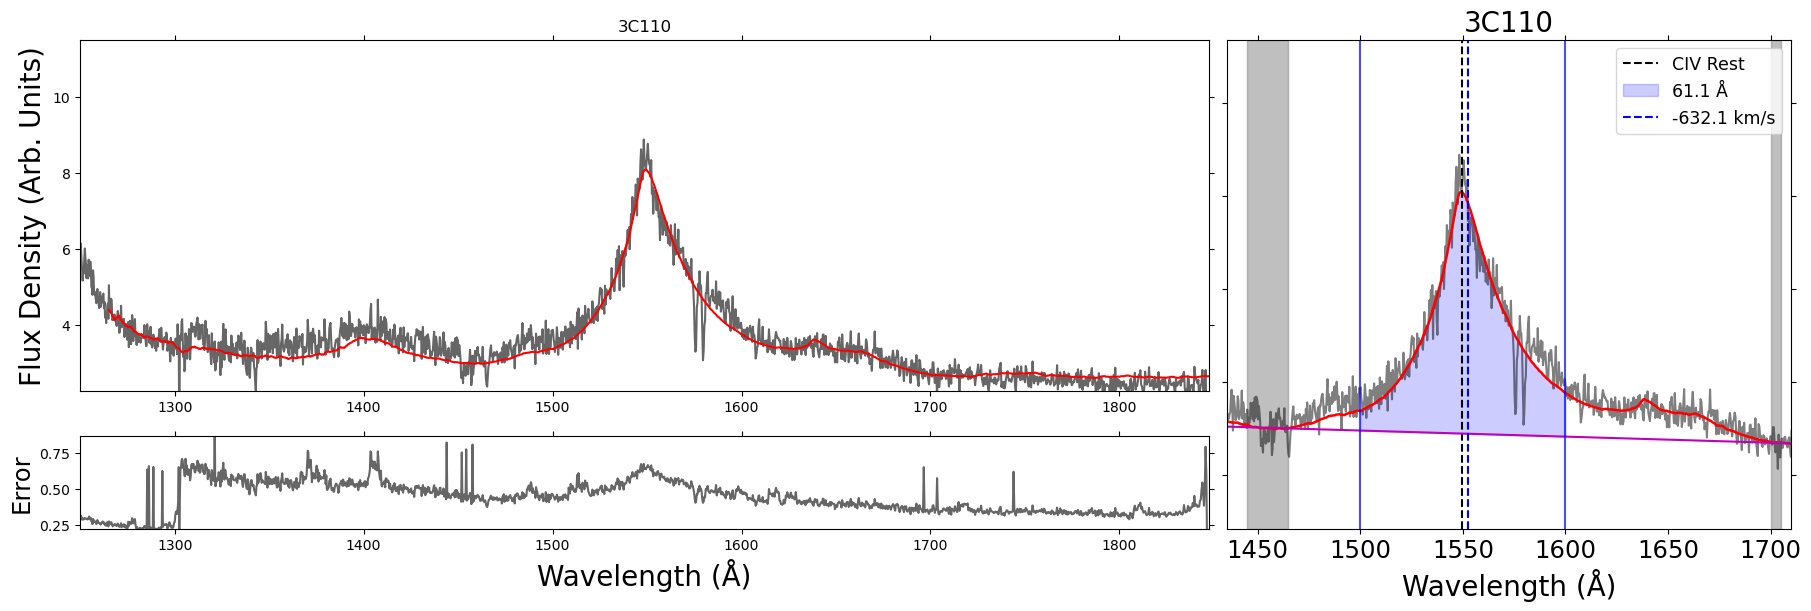

['RebinnedSpec_2022Aug11\\3C207_FOS.fits']


C:\Users\Alexandros Pratsos\AppData\Local\Temp\ipykernel_34700\2447717463.py:46: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0)


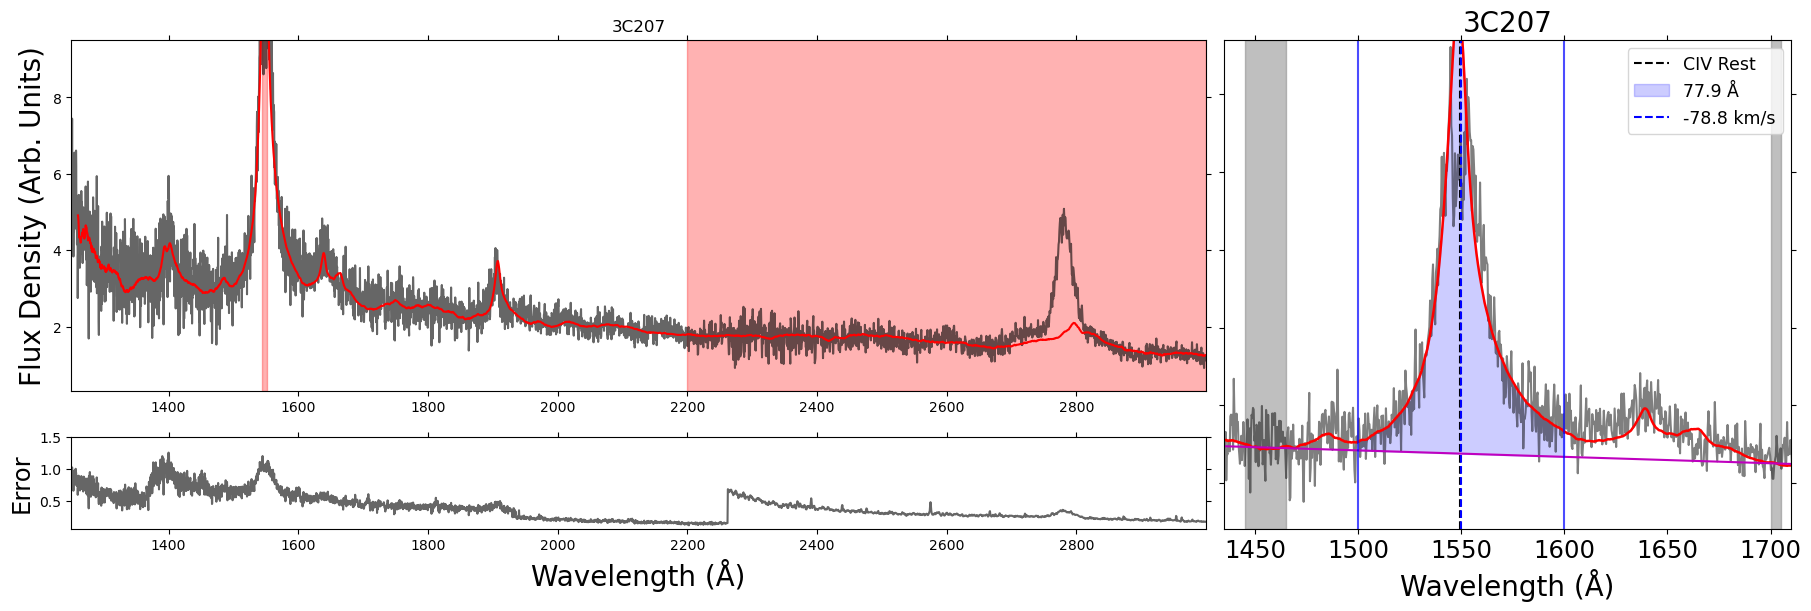

['RebinnedSpec_2022Aug11\\3C215_FOS.fits']


C:\Users\Alexandros Pratsos\AppData\Local\Temp\ipykernel_34700\2447717463.py:46: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0)


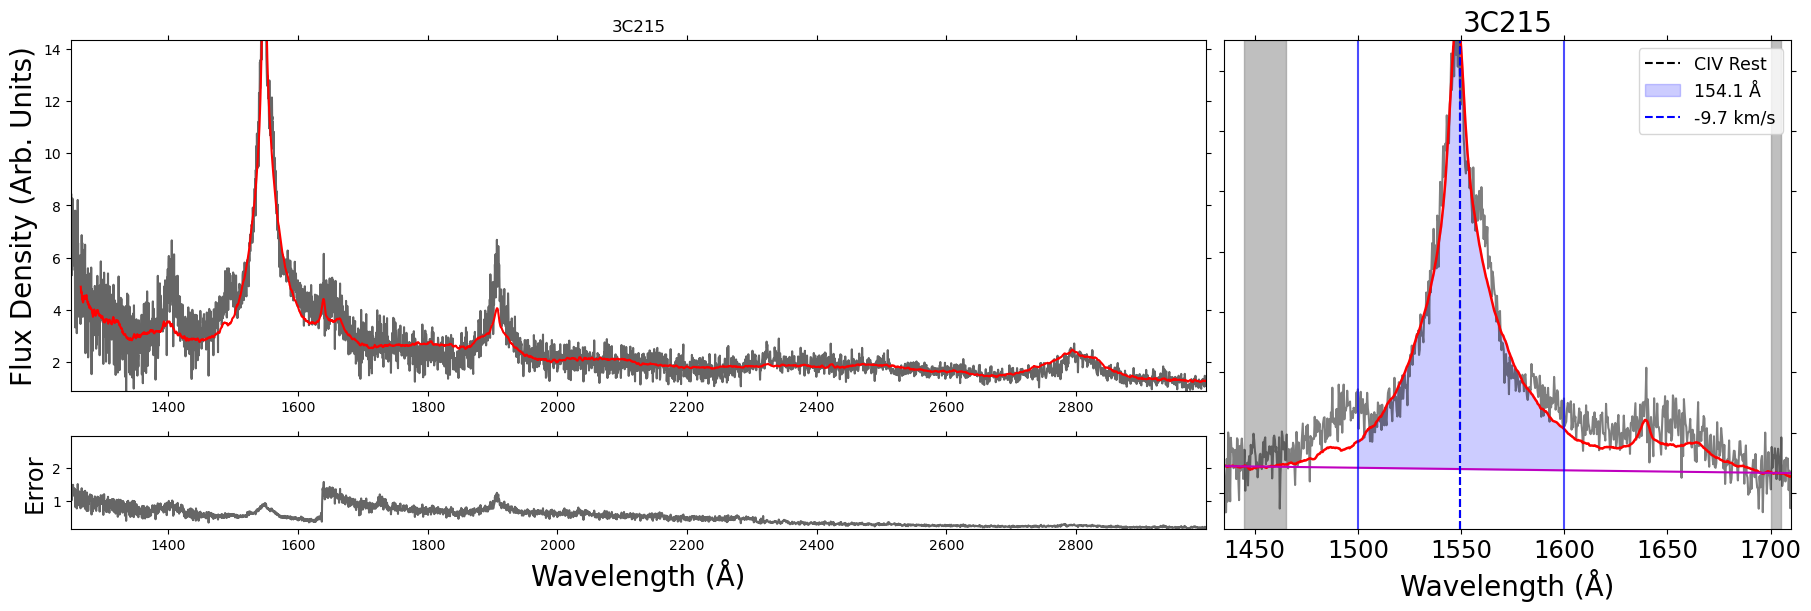

['RebinnedSpec_2022Aug11\\3C232_FOS.fits']
ind1: 95, ind2: 613.
ind1: 613, ind2: 1121.
ind1: 1121, ind2: 1863.
ind1: 1863, ind2: 2084.
ind1: 2084, ind2: 2518.
ind1: 2518, ind2: 2771.
ind1: 2771, ind2: 3273.
ind1: 3273, ind2: 3573.
ind1: 3573, ind2: 3756.
ind1: 3756, ind2: 4154.
ind1: 4154, ind2: 5010.
ind1: 5010, ind2: 5740.
ind1: 5740, ind2: 6247.
ind1: 6247, ind2: 6625.
ind1: 6625, ind2: 7378.


C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:197: RuntimeWarning: All-NaN slice encountered
  continuum = np.array([np.nanmedian(extended_data_array[l-filterval:l+filterval]) for l in np.arange(filterval,len(data)+filterval,1)])
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\spec_morph.py:369: RuntimeWarning: All-NaN slice encountered
  med_flux[k] = np.nanmedian(flux[(~em)&(waverange)])
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\fit_composites.py:68: RuntimeWarning: divide by zero encountered in divide
  fit_y  = fit_comp(composite_fit, wave[wavecoverage_mask][:-1], flux[wavecoverage_mask][:-1], 1/(errs[wavecoverage_mask][:-1]**2), mask[wavecoverage_mask][:-1])
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:321: RuntimeWarning: divide by zero encountered in divid

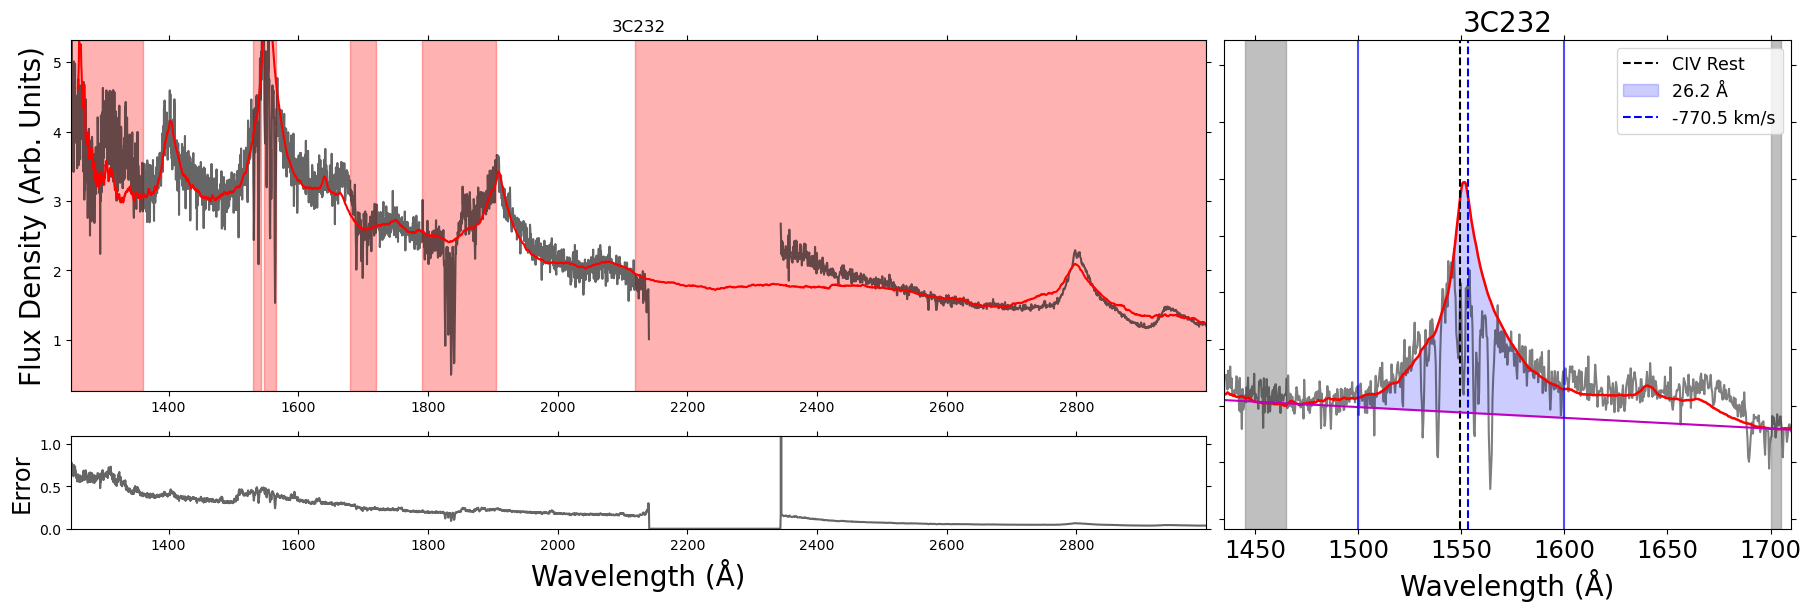

[]
3C249.1
['RebinnedSpec_2022Aug11\\3C254_FOS.fits']


C:\Users\Alexandros Pratsos\AppData\Local\Temp\ipykernel_34700\2447717463.py:46: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0)


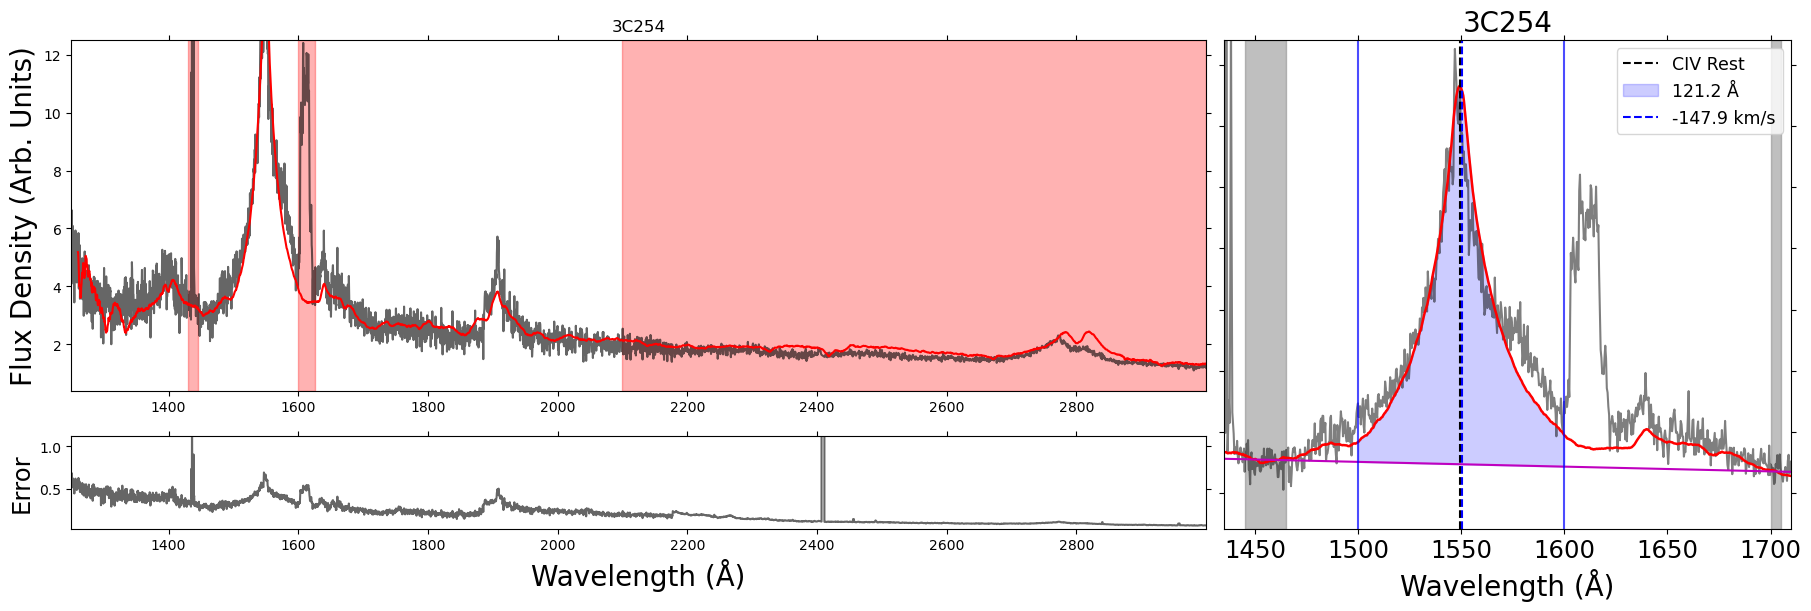

['RebinnedSpec_2022Aug11\\3C263_FOS.fits']
ind1: 96, ind2: 614.
ind1: 614, ind2: 1121.
ind1: 1121, ind2: 1863.
ind1: 1863, ind2: 2084.
ind1: 2084, ind2: 2518.
ind1: 2518, ind2: 2771.
ind1: 2771, ind2: 3573.
ind1: 3573, ind2: 3756.
ind1: 3756, ind2: 4117.


C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\fit_composites.py:68: RuntimeWarning: divide by zero encountered in divide
  fit_y  = fit_comp(composite_fit, wave[wavecoverage_mask][:-1], flux[wavecoverage_mask][:-1], 1/(errs[wavecoverage_mask][:-1]**2), mask[wavecoverage_mask][:-1])
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:321: RuntimeWarning: divide by zero encountered in divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1], priors=prior_mod)
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:330: RuntimeWarning: divide by zero encountered in divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1], priors=prior_low)
C:\Users\Alexandros Pratsos\

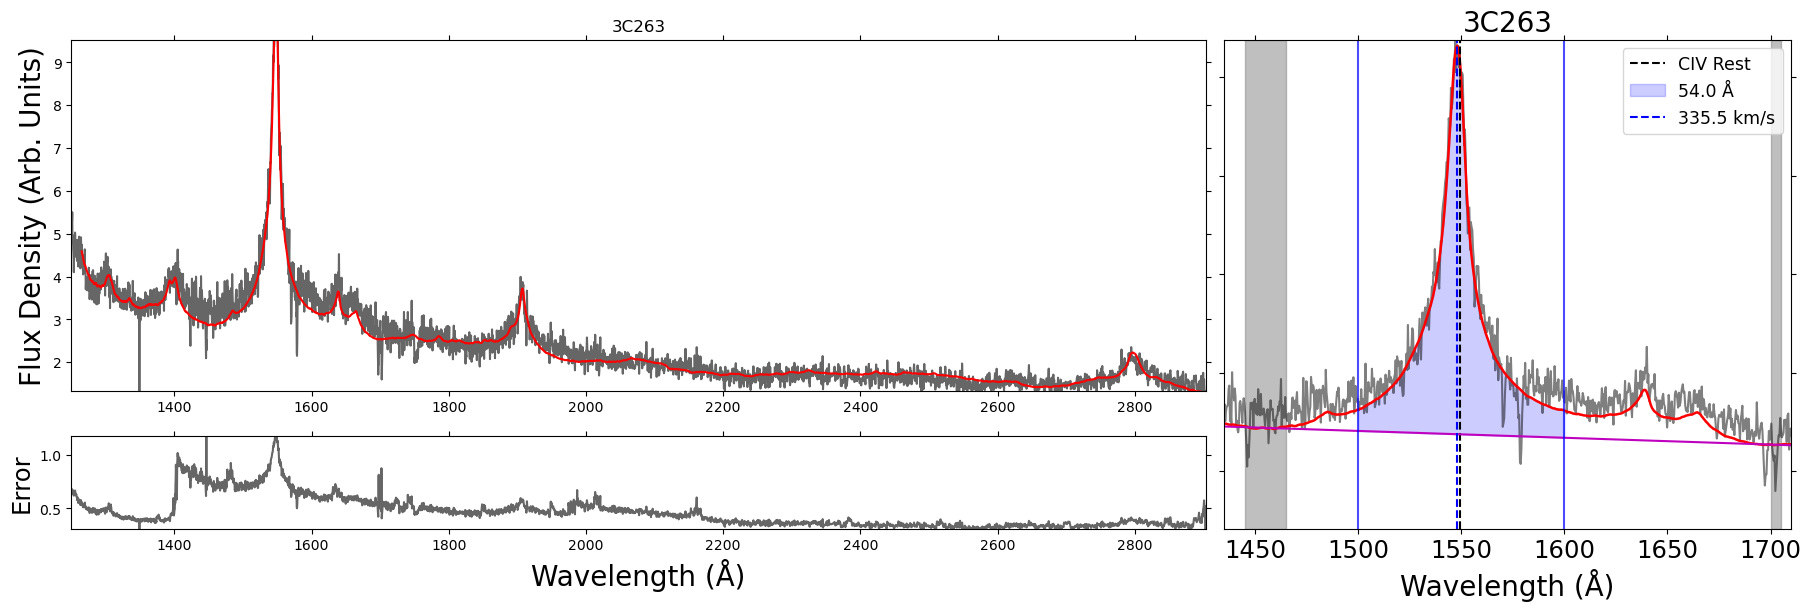

['RebinnedSpec_2022Aug11\\3C273_FOS.fits']


C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\fit_composites.py:68: RuntimeWarning: divide by zero encountered in divide
  fit_y  = fit_comp(composite_fit, wave[wavecoverage_mask][:-1], flux[wavecoverage_mask][:-1], 1/(errs[wavecoverage_mask][:-1]**2), mask[wavecoverage_mask][:-1])
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:321: RuntimeWarning: divide by zero encountered in divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1], priors=prior_mod)
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:330: RuntimeWarning: divide by zero encountered in divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1], priors=prior_low)
C:\Users\Alexandros Pratsos\

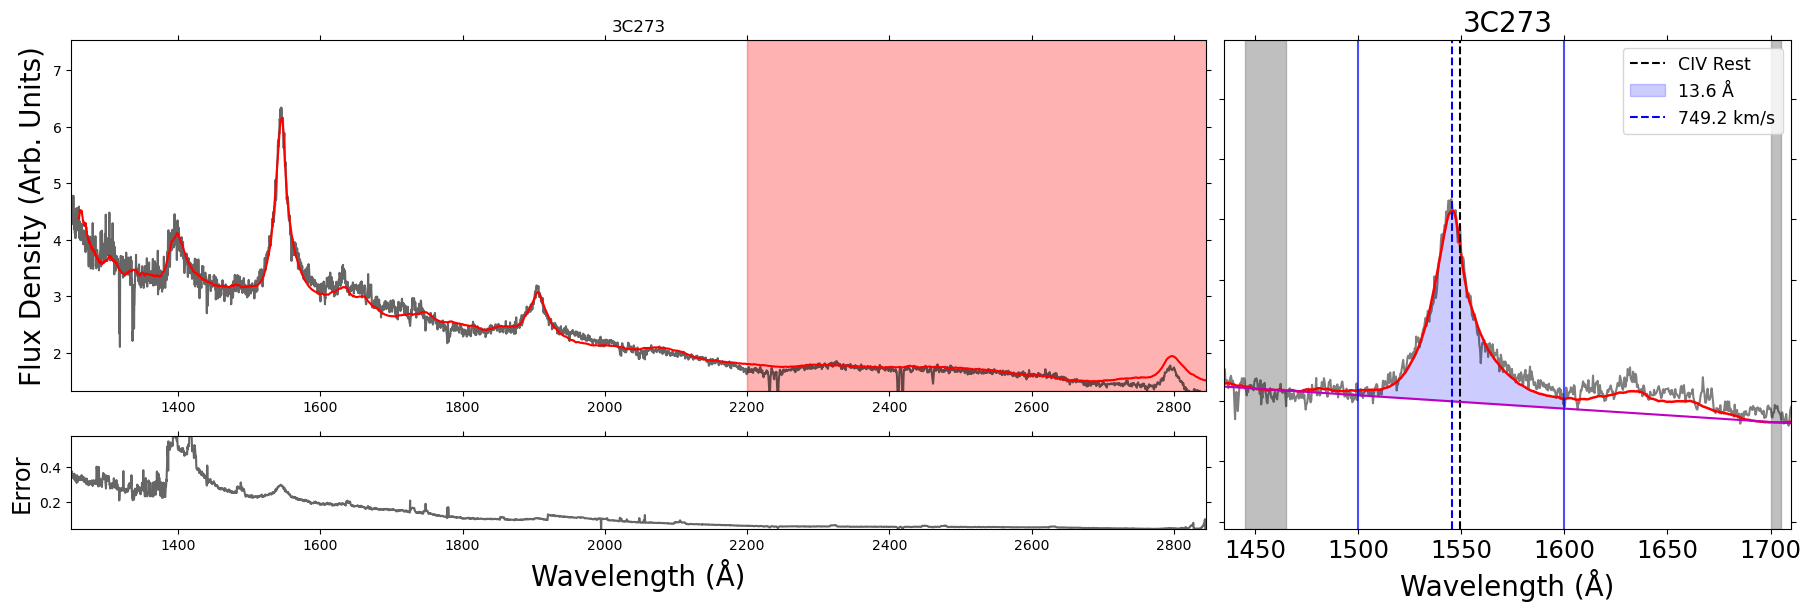

[]
3C277.1
['RebinnedSpec_2022Aug11\\3C281_FOS.fits']
ind1: 96, ind2: 613.
ind1: 613, ind2: 1121.
ind1: 1121, ind2: 1786.
ind1: 1786, ind2: 2084.
ind1: 2084, ind2: 2485.
ind1: 2485, ind2: 2582.
ind1: 2582, ind2: 2932.


C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\spec_morph.py:48: RuntimeWarning: All-NaN slice encountered
  [np.nanmedian(flux[(ind1-5):(ind1+5)]), np.nanmedian(flux[(ind2-5):(ind2+5)])],


LinAlgError: SVD did not converge in Linear Least Squares

In [14]:
ITERATE = True
print(inst_final)
path = "/RebinnedSpec_2022Aug11/"
for name,inst,i in zip(names,inst_final,range(len(dat))):
    # if i>=np.where(names=="SDSSJ145108.76+270926.9")[0][0]:
    # fn_list = glob.glob(path+"%s*%s.fits"%(name,inst))
    fn_list = glob.glob("RebinnedSpec_2022Aug11/%s*%s.fits"%(name,inst))
    #print(path + name + inst)
    print(fn_list)
    if len(fn_list)==0:
        print(name)
        continue
    else:
        fn = fn_list[0]
    spec = fits.open(fn)
    wave_orig = spec[1].data["Rest-Frame Wavelength"] #* ((1+.6953)/(1+.6992))
    flux_orig = spec[1].data["Coadded Flux (Arbitrary Units)"]
    z         = spec[1].data["Redshift"][0]
    flux_orig /= np.nanmedian(flux_orig)
    errs_orig = spec[1].data["Coadded Flux Errors"] / np.nanmedian(flux_orig)
    if name in MorphingEdges.MorphingEdges:
        flux_orig, morph_coeff, unique_markers = spec_morph.morph(wave_orig*(1+z), flux_orig, z, np.nanmedian(flux_orig), unique_markers=MorphingEdges.MorphingEdges[name], return_markers=True)
        errs_orig *= morph_coeff
    mask_orig = spec[1].data["Bad Pixel Mask"]
    #Mask manually defined BAL regions - NOT in first round
    if name in CIV_BAL_regions.BAL_regions:
        for window in CIV_BAL_regions.BAL_regions[name]:
            mask_orig[((wave_orig>=window[0])&(wave_orig<=window[1]))] = 1


    wave_arb, flux_arb, errs_arb, mask_arb, wave_ica, flux_ica, f2500_ica = \
    run_ICA_r20_components.main_ICA(wave_orig, flux_orig, errs_orig, mask_orig, z, name="", 
                                    ica_path="")

    c4mask = wave_arb>1400
    ylow, yhigh = max(0, np.nanpercentile(flux_arb, 1)), np.nanpercentile(flux_arb[c4mask], 99)+np.nanmedian(flux_arb[c4mask])
    ylow_err, yhigh_err = max(0, np.nanpercentile(errs_arb, 1)), np.nanpercentile(errs_arb, 99)
    #xlow, xhigh = max(min(wave_arb), 1360), min(max(wave_arb), max(wave_ica))
    xlow, xhigh = max(min(wave_arb), 1250), min(max(wave_arb), max(wave_ica))

    fig = plt.figure(figsize=(18,6), constrained_layout=True)
    gs  = GridSpec(4, 12, figure=fig)
    ax1 = fig.add_subplot(gs[:3,:8]) #ica reconstruction
    ax2 = fig.add_subplot(gs[:,8:])   #CIV fitting
    ax3 = fig.add_subplot(gs[3,:8], sharex=ax1)
    plt.subplots_adjust(hspace=0)

    ax1.plot(wave_arb, flux_arb, "-k", alpha=0.6)
    ax1.plot(wave_ica, flux_ica, "-r")

    ax3.plot(wave_arb, errs_arb, "-k", alpha=0.6)

    blue, ew = get_CIV(wave_arb, flux_arb, wave_ica, flux_ica, name, ax=ax2)

    if name in CIV_BAL_regions.BAL_regions:
        for window in CIV_BAL_regions.BAL_regions[name]:
            ax1.axvspan(window[0], window[1], color="r", alpha=0.3)

    """
    if name in MorphingEdges.MorphingEdges:
        for k in range(len(unique_markers)):
            ax1.plot([unique_markers[k],unique_markers[k]],[ylow,yhigh], "--")
    """

    ax1.set_xlim(xlow, xhigh)
    ax1.set_ylim(ylow, yhigh)
    ax1.set_title(name)
    ax3.set_xlim(xlow, xhigh)
    ax3.set_ylim(ylow_err, yhigh_err)
    ax1.set_ylabel("Flux Density (Arb. Units)", fontsize=20)
    ax3.set_xlabel("Wavelength (Å)", fontsize=20)
    ax3.set_ylabel("Error", fontsize=17.5)
    #plt.savefig("/Users/trevormccaffrey/Dropbox/HST/final_MarchApril2023/plots/ICA_full/%s_%s_fullICA_wCIV.png"%(name,inst))
    plt.show()
    #blue, EW = get_CIV(wave_orig, flux_orig, wave_reconst, reconstruction, name)
    #dat.at[names==name,dat.columns=="CIV_blue_tvm"] = blue
    #dat.at[names==name,dat.columns=="CIV_EW_tvm"]   = EW

    #re-save spectrum and reconstruction
    # t = Table([wave_arb,flux_arb,errs_arb,mask_arb,z*np.ones(len(wave_arb))],names=('Rest-frame Wavelength','Coadded Flux (Arbitrary Units)','Coadded Flux Errors','Bad Pixel Mask','Redshift'))
    # t.write("/Users/trevormccaffrey/Dropbox/HST/final_MarchApril2023/ICA_reconstructions_final_March2023/spectra_morphed/%s_%s_morphed.fits"%(name,inst), overwrite=True)
    # t_ica = Table([wave_ica,flux_ica],names=('ICA Wave','ICA Reconstruction'))
    # t_ica.write("/Users/trevormccaffrey/Dropbox/HST/final_MarchApril2023/ICA_reconstructions_final_March2023/reconstructions_final/%s_%s_ICA.fits"%(name,inst), overwrite=True)

    #break

['STIS' 'HSLA' 'FOS' 'FOS' 'HSLA' 'FOS' 'FOS' 'HSLA' 'FOS' 'HSLA' 'HSLA'
 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS'
 'FOS' 'FOS' 'FOS' 'FOS' 'STIS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS'
 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS'
 'HSLA' 'FOS' 'FOS' 'FOS' 'STIS' 'FOS' 'HSLA' 'HSLA' 'HSLA' 'FOS' 'HSLA'
 'FOS' 'HSLA' 'FOS' 'FOS' 'HSLA' 'FOS' 'HSLA' 'FOS' 'FOS' 'STIS' 'HSLA'
 'HSLA' 'FOS' 'FOS' 'FOS' 'HSLA' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'HSLA'
 'HSLA' 'HSLA' 'HSLA' 'HSLA' 'HSLA' 'HSLA' 'HSLA' 'HSLA' 'HSLA' 'FOS'
 'HSLA' 'HSLA' 'HSLA' 'HSLA' 'HSLA' 'FOS' 'STIS' 'STIS' 'FOS' 'HSLA'
 'HSLA' 'HSLA' 'FOS' 'FOS' 'FOS' 'STIS' 'HSLA' 'FOS' 'HSLA' 'STIS' 'STIS'
 'FOS' 'FOS' 'HSLA' 'HSLA' 'FOS' 'HSLA' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS'
 'HSLA' 'HSLA' 'HSLA' 'FOS' 'FOS' 'FOS' 'FOS' 'HSLA' 'FOS' 'FOS' 'FOS'
 'FOS' 'FOS' 'HSLA' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'FOS' 'STIS' 'FOS'
 'STIS' 'FOS' 'FOS' 'FOS' 'FOS' 'HSLA' 'FOS' 'FOS' 'STIS' 'FOS' 'HSLA

C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\fit_composites.py:68: RuntimeWarning: divide by zero encountered in divide
  fit_y  = fit_comp(composite_fit, wave[wavecoverage_mask][:-1], flux[wavecoverage_mask][:-1], 1/(errs[wavecoverage_mask][:-1]**2), mask[wavecoverage_mask][:-1])
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:321: RuntimeWarning: divide by zero encountered in divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1], priors=prior_mod)
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:330: RuntimeWarning: divide by zero encountered in divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1], priors=prior_low)
C:\Users\Alexandros Pratsos\

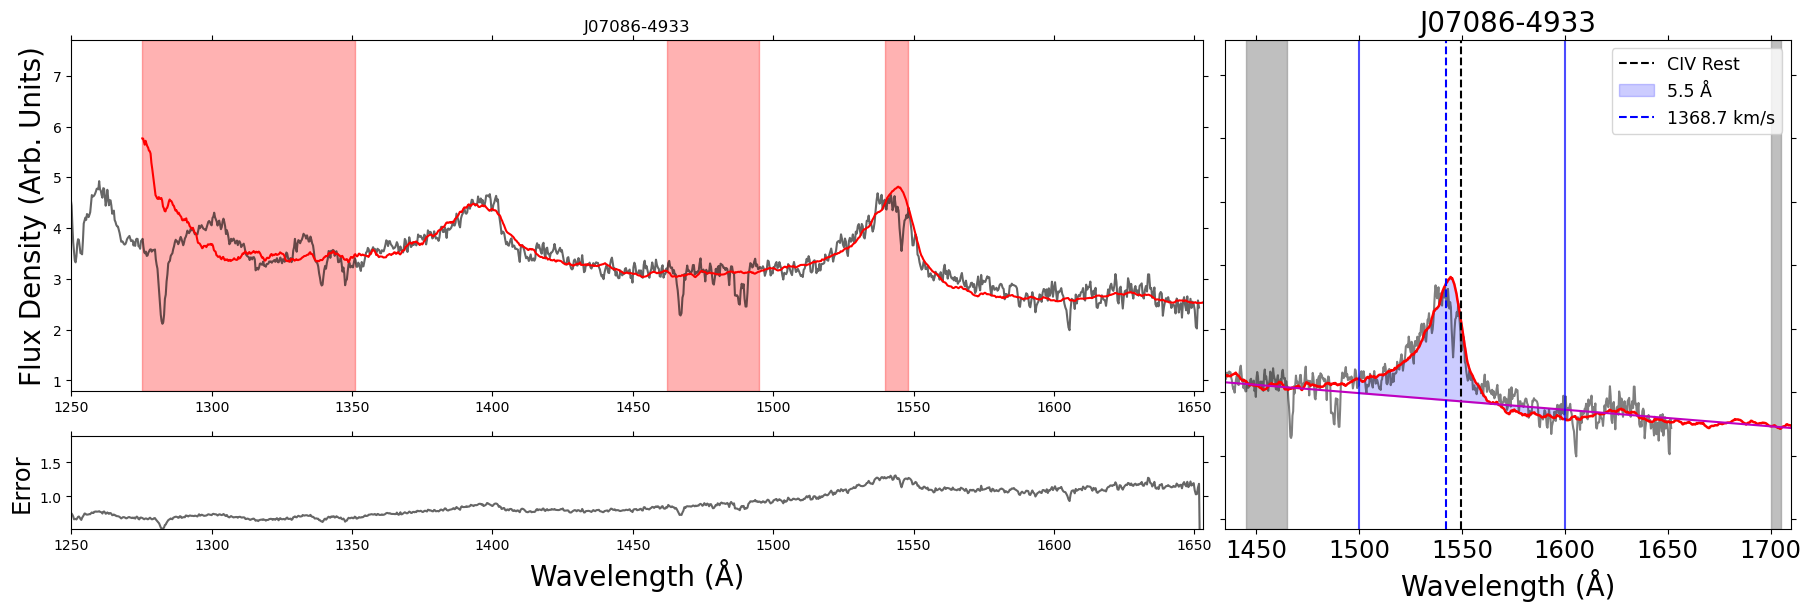

['RebinnedSpec_2022Aug11\\1H1613-097_coadd_FUVM_final_lpALL_HSLA.fits']


C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\fit_composites.py:68: RuntimeWarning: divide by zero encountered in divide
  fit_y  = fit_comp(composite_fit, wave[wavecoverage_mask][:-1], flux[wavecoverage_mask][:-1], 1/(errs[wavecoverage_mask][:-1]**2), mask[wavecoverage_mask][:-1])
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:321: RuntimeWarning: divide by zero encountered in divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1], priors=prior_mod)
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:330: RuntimeWarning: divide by zero encountered in divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1], priors=prior_low)
C:\Users\Alexandros Pratsos\

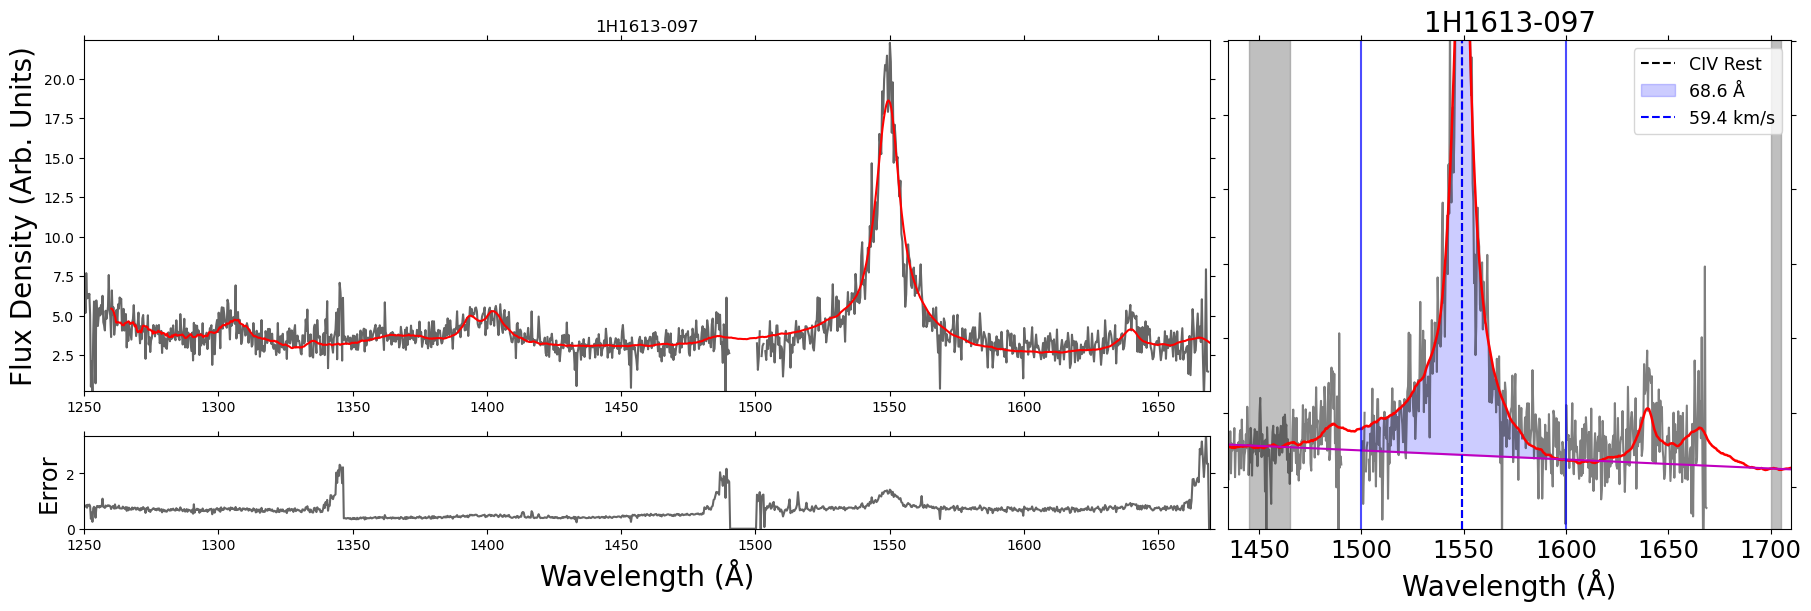

['RebinnedSpec_2022Aug11\\J04232-0120_FOS.fits']


C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\fit_composites.py:68: RuntimeWarning: divide by zero encountered in divide
  fit_y  = fit_comp(composite_fit, wave[wavecoverage_mask][:-1], flux[wavecoverage_mask][:-1], 1/(errs[wavecoverage_mask][:-1]**2), mask[wavecoverage_mask][:-1])
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:321: RuntimeWarning: divide by zero encountered in divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1], priors=prior_mod)
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:330: RuntimeWarning: divide by zero encountered in divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1], priors=prior_low)
C:\Users\Alexandros Pratsos\

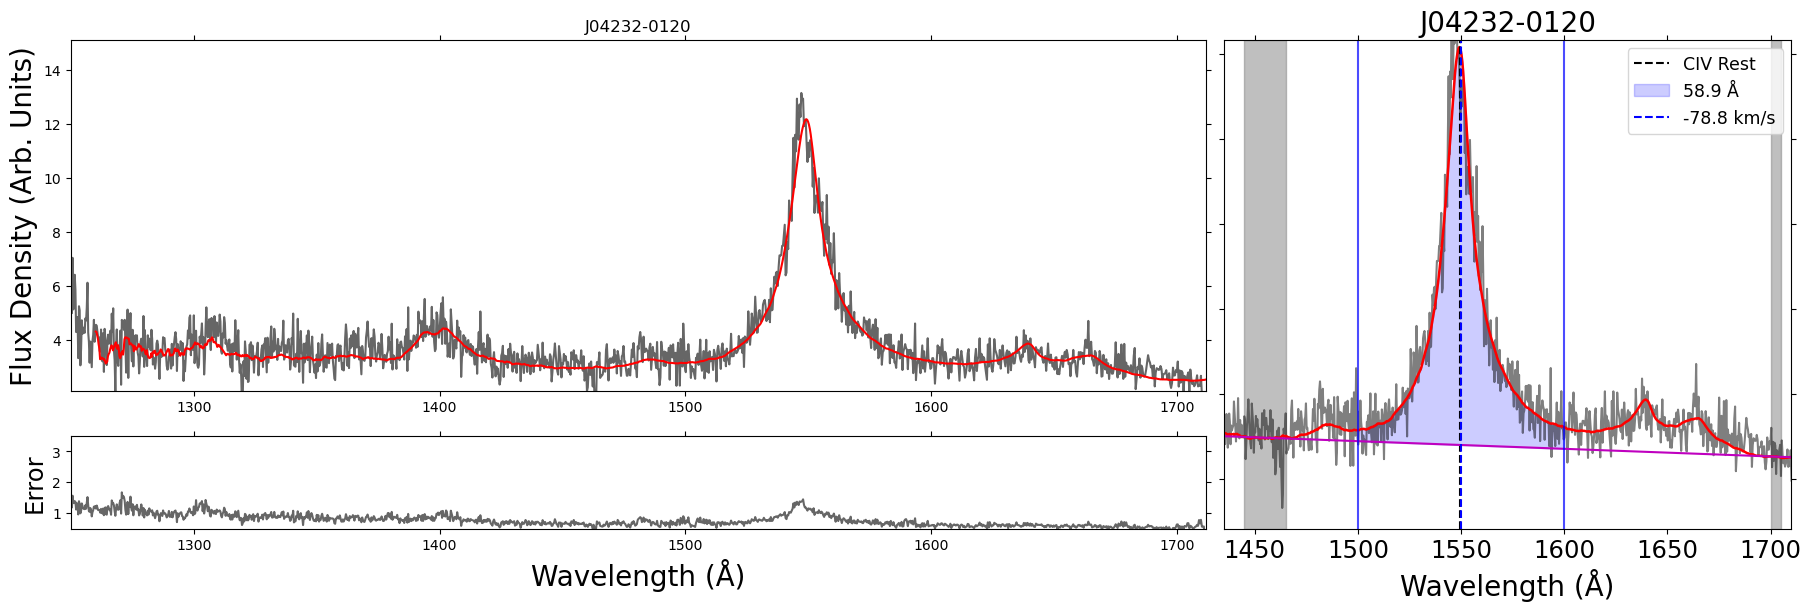

['RebinnedSpec_2022Aug11\\J04412-4313_FOS.fits']


C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\fit_composites.py:68: RuntimeWarning: divide by zero encountered in divide
  fit_y  = fit_comp(composite_fit, wave[wavecoverage_mask][:-1], flux[wavecoverage_mask][:-1], 1/(errs[wavecoverage_mask][:-1]**2), mask[wavecoverage_mask][:-1])
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:321: RuntimeWarning: divide by zero encountered in divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1], priors=prior_mod)
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:330: RuntimeWarning: divide by zero encountered in divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1], priors=prior_low)
C:\Users\Alexandros Pratsos\

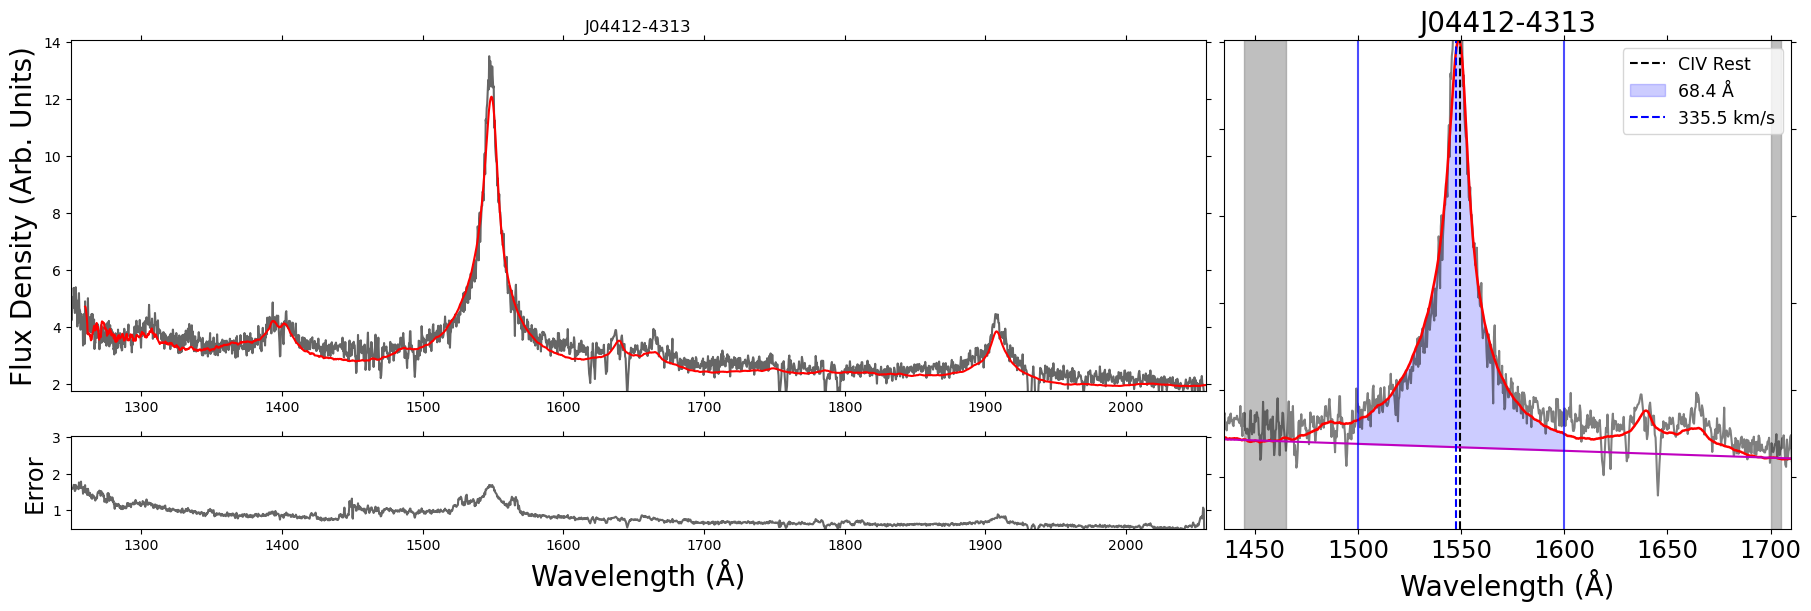

['RebinnedSpec_2022Aug11\\IRAS-L06229-6434_coadd_FUVM_final_lpALL_HSLA.fits']


C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\fit_composites.py:68: RuntimeWarning: divide by zero encountered in divide
  fit_y  = fit_comp(composite_fit, wave[wavecoverage_mask][:-1], flux[wavecoverage_mask][:-1], 1/(errs[wavecoverage_mask][:-1]**2), mask[wavecoverage_mask][:-1])
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:321: RuntimeWarning: divide by zero encountered in divide
  fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1], priors=prior_mod)
C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\run_ICA_r20_components.py:330: RuntimeWarning: divide by zero encountered in divide
  fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1], priors=prior_low)
C:\Users\Alexandros Pratsos\

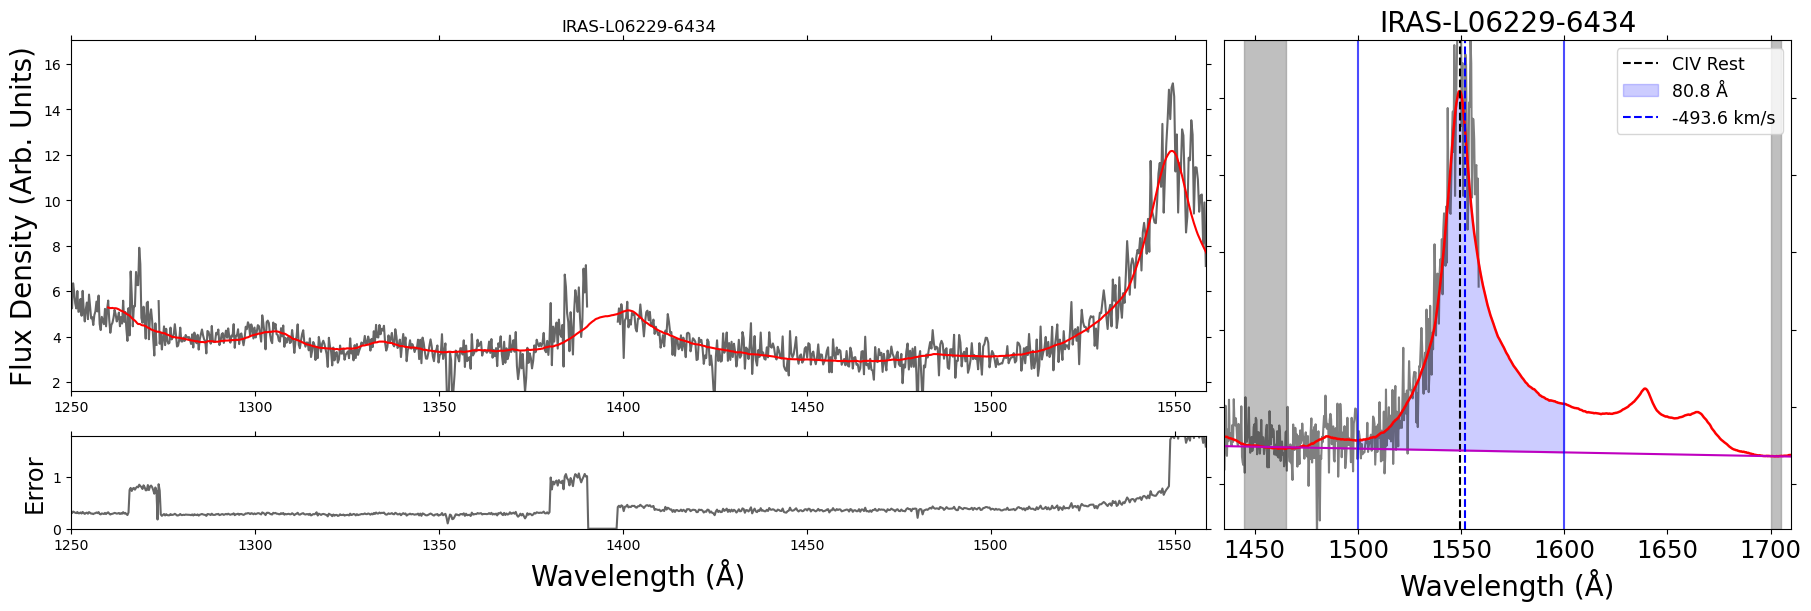

['RebinnedSpec_2022Aug11\\J12546+1141_FOS.fits']
[1145 1290 1450 1740 1810 1985 2045 2200 2660 2915 3550 4200 4720 5150
 6125 6850 7000]
ind1: 96, ind2: 614.
ind1: 614, ind2: 1122.
ind1: 1122, ind2: 1913.
ind1: 1913, ind2: 2085.


C:\Users\Alexandros Pratsos\PycharmProjects\Summer 2024\Richards\Trevor Code\ICA Scripts\spec_morph.py:48: RuntimeWarning: All-NaN slice encountered
  [np.nanmedian(flux[(ind1-5):(ind1+5)]), np.nanmedian(flux[(ind2-5):(ind2+5)])],


LinAlgError: SVD did not converge in Linear Least Squares

In [15]:
#----------------------AP Version----------------------------

ITERATE = True
print(inst_final)
path = "/RebinnedSpec_2022Aug11/"
for name,inst,i in zip(names_spec,inst_final,range(len(dat))):
    # if i>=np.where(names=="SDSSJ145108.76+270926.9")[0][0]:
    # fn_list = glob.glob(path+"%s*%s.fits"%(name,inst))
    fn_list = glob.glob("RebinnedSpec_2022Aug11/%s*%s.fits"%(name,inst))
    #print(path + name + inst)
    print(fn_list)
    if len(fn_list)==0:
        print(name)
        continue
    else:
        fn = fn_list[0]
    spec = fits.open(fn)
    wave_orig = spec[1].data["Rest-Frame Wavelength"] #* ((1+.6953)/(1+.6992))
    flux_orig = spec[1].data["Coadded Flux (Arbitrary Units)"]
    z         = spec[1].data["Redshift"][0]
    flux_orig /= np.nanmedian(flux_orig)
    errs_orig = spec[1].data["Coadded Flux Errors"] / np.nanmedian(flux_orig)
    if name in MorphingEdges.MorphingEdges:
        print(MorphingEdges.MorphingEdges[name])
        flux_orig, morph_coeff, unique_markers = spec_morph.morph(wave_orig*(1+z), flux_orig, z, np.nanmedian(flux_orig), unique_markers=MorphingEdges.MorphingEdges[name], return_markers=True)
        errs_orig *= morph_coeff
    mask_orig = spec[1].data["Bad Pixel Mask"]
    #Mask manually defined BAL regions - NOT in first round
    if name in CIV_BAL_regions.BAL_regions:
        for window in CIV_BAL_regions.BAL_regions[name]:
            mask_orig[((wave_orig>=window[0])&(wave_orig<=window[1]))] = 1


    wave_arb, flux_arb, errs_arb, mask_arb, wave_ica, flux_ica, f2500_ica = \
    run_ICA_r20_components.main_ICA(wave_orig, flux_orig, errs_orig, mask_orig, z, name="", 
                                    ica_path="")

    c4mask = wave_arb>1400
    ylow, yhigh = max(0, np.nanpercentile(flux_arb, 1)), np.nanpercentile(flux_arb[c4mask], 99)+np.nanmedian(flux_arb[c4mask])
    ylow_err, yhigh_err = max(0, np.nanpercentile(errs_arb, 1)), np.nanpercentile(errs_arb, 99)
    #xlow, xhigh = max(min(wave_arb), 1360), min(max(wave_arb), max(wave_ica))
    xlow, xhigh = max(min(wave_arb), 1250), min(max(wave_arb), max(wave_ica))

    fig = plt.figure(figsize=(18,6), constrained_layout=True)
    gs  = GridSpec(4, 12, figure=fig)
    ax1 = fig.add_subplot(gs[:3,:8]) #ica reconstruction
    ax2 = fig.add_subplot(gs[:,8:])   #CIV fitting
    ax3 = fig.add_subplot(gs[3,:8], sharex=ax1)
    plt.subplots_adjust(hspace=0)

    ax1.plot(wave_arb, flux_arb, "-k", alpha=0.6)
    ax1.plot(wave_ica, flux_ica, "-r")

    ax3.plot(wave_arb, errs_arb, "-k", alpha=0.6)

    blue, ew = get_CIV(wave_arb, flux_arb, wave_ica, flux_ica, name, ax=ax2)

    if name in CIV_BAL_regions.BAL_regions:
        for window in CIV_BAL_regions.BAL_regions[name]:
            ax1.axvspan(window[0], window[1], color="r", alpha=0.3)

    """
    if name in MorphingEdges.MorphingEdges:
        for k in range(len(unique_markers)):
            ax1.plot([unique_markers[k],unique_markers[k]],[ylow,yhigh], "--")
    """

    ax1.set_xlim(xlow, xhigh)
    ax1.set_ylim(ylow, yhigh)
    ax1.set_title(name)
    ax3.set_xlim(xlow, xhigh)
    ax3.set_ylim(ylow_err, yhigh_err)
    ax1.set_ylabel("Flux Density (Arb. Units)", fontsize=20)
    ax3.set_xlabel("Wavelength (Å)", fontsize=20)
    ax3.set_ylabel("Error", fontsize=17.5)
    #plt.savefig("/Users/trevormccaffrey/Dropbox/HST/final_MarchApril2023/plots/ICA_full/%s_%s_fullICA_wCIV.png"%(name,inst))
    plt.show()
    #blue, EW = get_CIV(wave_orig, flux_orig, wave_reconst, reconstruction, name)
    #dat.at[names==name,dat.columns=="CIV_blue_tvm"] = blue
    #dat.at[names==name,dat.columns=="CIV_EW_tvm"]   = EW

    #re-save spectrum and reconstruction
    # t = Table([wave_arb,flux_arb,errs_arb,mask_arb,z*np.ones(len(wave_arb))],names=('Rest-frame Wavelength','Coadded Flux (Arbitrary Units)','Coadded Flux Errors','Bad Pixel Mask','Redshift'))
    # t.write("/Users/trevormccaffrey/Dropbox/HST/final_MarchApril2023/ICA_reconstructions_final_March2023/spectra_morphed/%s_%s_morphed.fits"%(name,inst), overwrite=True)
    # t_ica = Table([wave_ica,flux_ica],names=('ICA Wave','ICA Reconstruction'))
    # t_ica.write("/Users/trevormccaffrey/Dropbox/HST/final_MarchApril2023/ICA_reconstructions_final_March2023/reconstructions_final/%s_%s_ICA.fits"%(name,inst), overwrite=True)

    #break

In [15]:
names, names_spec

(array(['1H 0707-495', '1H 1613-097', '2E 1013', '2E 1135', '2E 1644',
        '2E 2889', '2E 3345', '2E 4226', '2E 935',
        '2MASS J00481898+3941116', '2MASS J10053274-2417161', '3C 057',
        '3C 095', '3C 110', '3C 207', '3C 215', '3C 232', '3C 249.1',
        '3C 254', '3C 263', '3C 273', '3C 277.1', '3C 281', '3C 323.1',
        '3C 334', '3C 336', '3C 345', '3C 351.0', '3C 390', '3C 454',
        '4C -01.61', '4C -03.79', '4C 01.04', '4C 09.72', '4C 09.74',
        '4C 10.06', '4C 11.72', '4C 15.01', '4C 16.30', '4C 19.44',
        '4C 31.63', '4C 37.43', '4C 39.25', '4C 49.22', '4C 61.20',
        '4C 63.15', '4C 73.18', '6C 134441+623604', '7C 1156+2123',
        '7C 1821+6419', 'Ark 120', 'Ark 564', 'Crt A', 'ESO 31-8',
        'ESO 462-9', 'ESO 499-41', 'Fairall 9', 'FBQS J0012-1022',
        'FBQS J0745+3142', 'FBQS J1010+3003', 'FBQS J1010+4132',
        'FBQS J1030+3102', 'FBQS J1251+2404', 'HE 0132-4313',
        'HS 0033+4300', 'HS 0624+6907', 'I Zw 1', 'IRAS 132

In [ ]:
get_CIV?

In [ ]:
(dat["ICA_Mask_Converge?"]==0).sum()

In [ ]:
dat.iloc[names=="IZW1",:]

In [16]:
names[5]

'2E 2889'